# Fonctions pour le calcul avec le maximum de la vraisemblance

## Lecture et nettoyage des données (code fourni)

In [261]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase, GaussianMixtures, IterTools, DelimitedFiles, MLBase

In [262]:
train = CSV.read("ODtrain.csv")
n = size(train,1)
p = size(train,2)
dropmissing!(train, disallowmissing=true)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

#string mode
d = Array{String}(undef,n)
for i=1:length(str_mode)
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
end
train[:D_Mode_str] = d

#nearest between train, metro and downtown
d = Array{Float64}(undef,n)
for i=1:n
    d[i] = min(train[i,[:M_dist_train, :M_dist_metro, :M_dist_centre]]...) 
end
train[:M_nearest] = d

#time of departure rounded to nearest hour 
d = Array{Int64}(undef,n)
for i=1:n
    h = train[i, :D_HREDE]
    d[i] = (h % 100) > 30 ? h + 100 - h % 100 : h - h % 100
    if d[i] == 0
        d[i] = 1
    end
end
train[:D_HREDE] = d

#group sectors by towns
d = Array{Int64}(undef,n)
for i=1:length(train[:M_DOMSM])
    mun = train[:M_DOMSM][i];
    if mun == 101 || mun == 102
        d[i] = 1;
    elseif (mun >= 103 && mun <= 112) || (mun >= 120 && mun <= 124)
        d[i] = 2;
    elseif mun >= 113 && mun <= 118
        d[i] = 3;
    elseif mun >= 126 && mun <= 141
        d[i] = 4;
    elseif mun >= 301 && mun <= 310
        d[i] = 5;
    elseif mun >= 401 && mun <= 408
        d[i] = 6;
    elseif mun >= 501 && mun <= 576
        d[i] = 7;
    elseif mun >= 601 && mun <= 691
        d[i] = 8;
    else
        d[i] = 9;
    end
end
train[:M_DOMSM_G] = d

categorical!(train, :D_Mode_str);

first(train,50)

,IPERE,Menage,M_AUTO,M_PERS,M_DOMSM,M_revenu,M_dist_train,M_dist_metro,M_dist_centre,M_emploiTC,P_RANG,P_SEXE,P_AGE,P_GRAGE,P_STATUT,P_PERMIS,D_HREDE,D_MOTIF,D_Mode,D_Mode_str,M_nearest,M_DOMSM_G
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Categorical…,Float64,Int64
1,9,1000013,2,3,110,6,7.71979,1.81961,9.44328,556670,2,1,47,10,1,1,700,1,1,Voiture,1.81961,2
2,17,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,1,1,46,10,3,1,600,4,2,Transport Collectif,2.35297,3
3,21,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,3,1,47,10,1,2,500,1,2,Transport Collectif,2.35297,3
4,31,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,7,1,21,5,3,2,700,4,2,Transport Collectif,2.35297,3
5,29,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,6,2,54,11,1,1,600,1,1,Voiture,2.35297,3
6,25,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,5,1,56,12,1,1,600,1,1,Voiture,2.35297,3
7,23,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,4,1,63,13,1,2,700,1,4,Actif,2.35297,3
8,19,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,2,2,15,4,3,5,800,4,4,Actif,2.35297,3
9,39,1000016,0,1,406,2,3.12452,0.689126,12.9415,658600,1,1,32,7,1,1,800,1,2,Transport Collectif,0.689126,6


## Analyse des distributions des données

Ici on peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

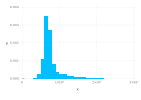

In [263]:
dep = 2; #1:voiture, 2:transport collectif, 3:voiture + transport collectif, 4:actif, 5 autre
sym = :D_HREDE
dist = Normal

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

## Fonctions pour le calcul

### Constante

In [264]:
k = 5

5

### Déclaration de types utilisés

In [265]:
struct MelangeNormales
    n::Int64
end

### Fonctions internes ("privées")

In [266]:
function determineMode(index::Int64, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = log(pdf(τ, i))
        for varExp in columns
           p[i] += log(pdf(dist[varExp][i], testSet[varExp][index]))
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end

function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    
    out = ""
    for i=1:k
        #print(str_mode[i], " : ", right[i]/nEach[i]*100, "%\n" ) 
        out *= str_mode[i] * " : " * string(right[i]/nEach[i]*100) * "%\n"
    end
    #print("Total : ", sum(right)/n*100, "%\n" )
    tot = sum(right)/n*100
    out *= "Total : " * string(tot) * "%\n"
    return (total=tot, output=out)
end

struct TestSet
    train::DataFrame
    test::DataFrame
end

function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end

function getEstimation(distType::Array{Any, 2}, columns::Array{Symbol, 1}, set::TestSet)
    # Maximum de la vraisemblance pour estimer
    nVariablesExpl = length(columns)
    for iVarExpl in 1:nVariablesExpl
        if !haskey(dist, columns[iVarExpl])
            dist[columns[iVarExpl]] = Array{Distribution}(undef, k)
            fitDistributions(distType[iVarExpl,:], columns[iVarExpl], set)
        end
    end
    amount = length(set.test[:IPERE])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, columns, set.test) 
    end
    return res
end

function fitDistributions(distType::Array{Any, 1}, varExpl::Symbol, set::TestSet)
    for mode=1:k
        trainT = set.train[set.train[:D_Mode] .== mode, :];
        if typeof(distType[mode]) == MelangeNormales
            gmm = GMM(distType[mode].n, trainT[varExpl]; method=:kmeans, nInit=100, nIter=20)
            dist[varExpl][mode] = MixtureModel(gmm)
        else
             # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
            dist[varExpl][mode] = fit_mle(distType[mode], trainT[varExpl])
        end
    end
end

fitDistributions (generic function with 2 methods)

### Fonction "publique"

In [282]:
function getPercentRight(distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    set = getTestSet(train)
    estimation = getEstimation(distType, columns, set)
    print(validate(estimation, set.test[:D_Mode]).output)
end

#Evaluates all the models made from the combinations of up to $maxNVars variables contained in $columns and returns the best one
function getBestModels(maxNVars::Int64, distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    #build the combinations of up to maxNVars
    subsetIndices = [] 
    for i in 1:maxNVars
        append!(subsetIndices, [j for j in subsets(1:length(columns), i)])
    end
    
    #generate the results for all models
    set = getTestSet(train)
    results = Array{NamedTuple}(undef, length(subsetIndices))
    for i in 1:length(subsetIndices)
        indices = subsetIndices[i]
        println("now testing: ", columns[indices])
        estimation = getEstimation(distType[indices, :], columns[indices], set)
        tot, out = validate(estimation, set.test[:D_Mode])
        results[i] = (total=tot, output=out, columns=columns[indices], distType=distType[indices,:])
    end
    
    #rank models and return ranking
    sort!(results, by = x -> x.total, rev=true)
    print("Best model: ", results[1].columns, "\n", results[1].output)
    return results
end

function crossValidate(distType::Array{Any, 2}, columns::Array{Symbol, 1}, k::Int)
    scores = Float64[]
    for (i, train_inds) in enumerate(Kfold(n, k))
        #reset global known distributions
        dist = Dict()
        
        test_inds = setdiff(1:n, train_inds)
        set = TestSet(train[train_inds, :], train[test_inds, :])
        estimation = getEstimation(distType, columns, set)
        score = validate(estimation, set.test[:D_Mode]).total
        push!(scores, score)
    end
    
    return (mean, stddev) = mean_and_std(scores)
end

function generateSubmission(distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    test = CSV.read("ODtest.csv")
    submission = test[:, [:IPERE]]
    set = TestSet(train, test)
    estimation = getEstimation(distType, columns, set)
    submission = DataFrame(IPERE = test[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmission (generic function with 2 methods)

### Exemple

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle.
On pense la même chose pour la variable P_STATUT.
Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma.

Pour les trois variables, nous avons donné la même distribution peut-importe la valeur de Y.
Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire:
Gamma Gamma Normal Gamma Gamma

Les fonctions ci-dessus séparent l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.
Le résultat de l'appel à getPercentRight est séparé selon le mode de transport.

In [259]:
#reset global known distributions
dist = Dict()

getPercentRight([
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Poisson Poisson Poisson Poisson Poisson];
            [MelangeNormales(6) MelangeNormales(5) MelangeNormales(5) MelangeNormales(6) MelangeNormales(7)];
        ], [
            :P_PERMIS,
            :P_AGE,
            :D_MOTIF,
            :D_HREDE,
            :M_DOMSM,
            :M_AUTO,
            :M_dist_train
        ])

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.922864e+04
      1       3.337700e+04      -5.851637e+03 |        5
      2       3.181734e+04      -1.559661e+03 |        5
      3       3.078366e+04      -1.033679

┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28721 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


e+03 |        5
      4       2.995847e+04      -8.251936e+02 |        5
      5       2.912533e+04      -8.331384e+02 |        5
      6       2.811647e+04      -1.008858e+03 |        5
      7       2.713797e+04      -9.785059e+02 |        5
      8       2.647001e+04      -6.679531e+02 |        5
      9       2.595377e+04      -5.162393e+02 |        4
     10       2.560987e+04      -3.439086e+02 |        4
     11       2.533952e+04      -2.703451e+02 |        5
     12       2.515828e+04      -1.812394e+02 |        5
     13       2.505772e+04      -1.005597e+02 |        5
     14       2.496395e+04      -9.377358e+01 |        5
     15       2.485927e+04      -1.046804e+02 |        6
     16       2.462982e+04      -2.294435e+02 |        6
     17       2.437258e+04      -2.572422e+02 |        6
     18       2.404907e+04      -3.235138e+02 |        6
     19       2.379061e+04      -2.584585e+02 |        6
     20       2.343960e+04      -3.510072e+02 |        6
     21       2

┌ Info: K-means with 6000 data points using 56 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.143705
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.129660
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.126297
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.124979
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.124309
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.290187e+04
      1       8.577281e+03      -4.324588e+03 |        5


┌ Info: iteration 17, average log likelihood -3.122050
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.121930
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.121813
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.121699
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: EM with 28721 data points 20 iterations avll -3.121699
│ 1689.5 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: Initializing GMM, 5 Gaussians LinearAlgebra.diag covariance 1 dimensions using 11672 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


      2       8.539615e+03      -3.766540e+01 |        4
      3       8.537364e+03      -2.251343e+00 |        2
      4       8.537244e+03      -1.199165e-01 |        2
      5       8.537229e+03      -1.527623e-02 |        0
      6       8.537229e+03       0.000000e+00 |        0
K-means converged with 6 iterations (objv = 8537.228682148521)


┌ Info: K-means with 5000 data points using 6 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0      

┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.610868
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.593189
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.589016
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.587372
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.586550
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 6, average log likelihood -2.586068
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtur

 1.015164e+04
      1       5.574070e+03      -4.577567e+03 |        5
      2       5.197228e+03      -3.768418e+02 |        5
      3       5.073425e+03      -1.238030e+02 |        4
      4       5.021412e+03      -5.201347e+01 |        3
      5       5.008129e+03      -1.328343e+01 |        3
      6       5.003264e+03      -4.864361e+00 |        3
      7       4.996260e+03      -7.004606e+00 |        4
      8       4.990764e+03      -5.495737e+00 |        4
      9       4.988514e+03      -2.249487e+00 |        3
     10       4.988150e+03      -3.642267e-01 |        0
     11       4.988150e+03       0.000000e+00 |        0
K-means converged with 11 iterations (objv = 4988.150161149513)


┌ Info: K-means with 1664 data points using 11 iterations
│ 166.4 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.999315
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.984711
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.981218
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.979777
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.978980
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.613039e+04
      1       1.891728e+04      -7.213112e+03 |        6
      2       1.801488e+04      -9.023987e+02 |        6
      3       1.777092e+04      -2.439565e+02 |        6
      4       1.768972e+04      -8.120300e+01 |        6
      5       1.768233e+04      -7.390572e+00 |        5
      6       1.768095e+04      -1.379181e+00 |        2
      7       1.767852e+04      -2.430584e+00 |        3
      8       1.767682e+04      -1.692594e+00 |        3
      9       1.767658e+04      -2.419549e-01 |        3
     10       1.767640e+04      -1.822929e-01 |        3
     11       1.767637e+04      -3.233684e-02 |        0
     12       1.767637e+04       0.000000e+00 |        0
K-means converged with 12 iterations (objv = 17676.367661286407)
  Iters               objv        objv-change | affected 
----------------------------------------------

┌ Info: K-means with 6000 data points using 12 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.818597
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.797591
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.790931
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.787527
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.785419
└ @ GaussianMixtures C:\

   1       1.139307e+04      -7.449371e+03 |        7
      2       1.068993e+04      -7.031399e+02 |        7
      3       1.054769e+04      -1.422399e+02 |        6
      4       1.046660e+04      -8.108849e+01 |        6
      5       1.038097e+04      -8.562941e+01 |        6
      6       1.030359e+04      -7.737658e+01 |        4
      7       1.024686e+04      -5.673367e+01 |        5
      8       1.021666e+04      -3.020086e+01 |        6
      9       1.019911e+04      -1.754411e+01 |        6
     10       1.017663e+04      -2.248238e+01 |        5
     11       1.013542e+04      -4.121183e+01 |        5
     12       1.011182e+04      -2.359493e+01 |        6
     13       1.009254e+04      -1.928712e+01 |        5
     14       1.007320e+04      -1.933496e+01 |        5
     15       1.005731e+04      -1.589318e+01 |        4
     16       1.005302e+04      -4.293403e+00 |        4
     17       1.005126e+04      -1.758322e+00 |        4
     18       1.005007e+04      -1

┌ Info: K-means with 4058 data points using 21 iterations
│ 289.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.322250
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.306539
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.302698
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.301171
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.300383
└ @ GaussianMixtures C:\

Voiture : 80.26225925420025%
Transport Collectif : 48.23529411764706%
Hybride : 0.45871559633027525%
Actif : 30.576271186440678%
Autre : 84.7328244274809%
Total : 65.27348170501698%


In [257]:
#reset global known distributions
dist = Dict()

generateSubmission([
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Poisson Poisson Poisson Poisson Poisson];
            [MelangeNormales(6) MelangeNormales(5) MelangeNormales(5) MelangeNormales(6) MelangeNormales(7)];
        ], [
            :P_PERMIS,
            :P_AGE,
            :D_MOTIF,
            :D_HREDE,
            :M_DOMSM,
            :M_AUTO,
            :M_dist_train
        ])

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.341342e+04
      1       2.397555e+

┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 1 dimensions using 36042 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


04      -9.437873e+03 |        6
      2       2.223940e+04      -1.736146e+03 |        6
      3       2.137164e+04      -8.677624e+02 |        5
      4       2.079358e+04      -5.780553e+02 |        5
      5       2.038272e+04      -4.108663e+02 |        5
      6       2.003289e+04      -3.498272e+02 |        5
      7       1.973775e+04      -2.951343e+02 |        5
      8       1.941158e+04      -3.261795e+02 |        5
      9       1.897795e+04      -4.336299e+02 |        5
     10       1.825629e+04      -7.216529e+02 |        5
     11       1.753785e+04      -7.184466e+02 |        5
     12       1.702439e+04      -5.134568e+02 |        5
     13       1.669827e+04      -3.261197e+02 |        5
     14       1.653003e+04      -1.682429e+02 |        5
     15       1.645500e+04      -7.502442e+01 |        5
     16       1.639360e+04      -6.140438e+01 |        5
     17       1.633976e+04      -5.384216e+01 |        4
     18       1.630941e+04      -3.034691e+01 |        

┌ Info: K-means with 6000 data points using 34 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.144678
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.128683
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.125068
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.123687
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.123000
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.592904e+04
      1       1.179824e+04      -4.130795e+03 |        5
      2       

┌ Info: iteration 15, average log likelihood -3.121069
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.120952
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.120839
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.120730
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.120624
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.120521
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: EM with 36042 data points 20 iterations avll -3.120521
│ 2120.1 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\pac

1.135498e+04      -4.432627e+02 |        5
      3       1.119734e+04      -1.576431e+02 |        5
      4       1.098502e+04      -2.123191e+02 |        5
      5       1.081394e+04      -1.710768e+02 |        5
      6       1.050568e+04      -3.082638e+02 |        5
      7       1.001301e+04      -4.926703e+02 |        5
      8       9.485541e+03      -5.274662e+02 |        5
      9       9.066303e+03      -4.192380e+02 |        5
     10       8.798631e+03      -2.676716e+02 |        4
     11       8.671270e+03      -1.273619e+02 |        4
     12       8.595266e+03      -7.600341e+01 |        4
     13       8.559797e+03      -3.546912e+01 |        4
     14       8.543990e+03      -1.580710e+01 |        4
     15       8.528912e+03      -1.507756e+01 |        3
     16       8.521307e+03      -7.605364e+00 |        4
     17       8.514164e+03      -7.142625e+00 |        3
     18       8.506108e+03      -8.056766e+00 |        3
     19       8.495867e+03      -1.024014e+01

┌ Info: K-means with 5000 data points using 26 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.614776
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.598626
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.594775
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.593260
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.592499
└ @ GaussianMixtures C:\

    0       1.057516e+04
      1       7.930080e+03      -2.645084e+03 |        4
      2       7.800052e+03      -1.300280e+02 |        4
      3       7.786901e+03      -1.315122e+01 |        4
      4       7.784512e+03      -2.388787e+00 |        4
      5       7.783990e+03      -5.220272e-01 |        3
      6       7.783908e+03      -8.220138e-02 |        2
      7       7.783764e+03      -1.433921e-01 |        3
      8       7.783631e+03      -1.337049e-01 |        0
      9       7.783631e+03       0.000000e+00 |        0
K-means converged with 9 iterations (objv = 7783.6305074031725)


┌ Info: K-means with 2100 data points using 9 iterations
│ 210.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.986665
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.972058
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.968405
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.966824
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.965897
└ @ GaussianMixtures C:\U

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.652722e+04
      1       1.361282e+04      -2.914401e+03 |        6
      2       1.290597e+04      -7.068551e+02 |        5
      3       1.248888e+04      -4.170900e+02 |        5
      4       1.213386e+04      -3.550169e+02 |        5
      5       1.192665e+04      -2.072070e+02 |        4
      6       1.183498e+04      -9.167095e+01 |        4
      7       1.178261e+04      -5.236799e+01 |        4
      8       1.176044e+04      -2.217625e+01 |        4
      9       1.174155e+04      -1.888484e+01 |        4
     10       1.173307e+04      -8.484377e+00 |        5
     11       1.172838e+04      -4.689693e+00 |        3
     12       1.172678e+04      -1.599220e+00 |        3
     13       1.172617e+04      -6.051440e-01 |        3
     14       1.172598e+04      -1.968930e-01 |        2
     15       1.172595e+04      -2.608344e-02 |        

┌ Info: K-means with 6000 data points using 20 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243


┌ Info: iteration 1, average log likelihood -2.789868
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.775110
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.771572
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.770175
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.769457
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 6, average log likelihood -2.769014
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 7, average log likelihood -2.768700
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info

 Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.753241e+04
      1       1.425726e+04      -1.327514e+04 |        6
      2       1.387831e+04      -3.789556e+02 |        6
      3       1.373550e+04      -1.428117e+02 |        6
      4       1.365774e+04      -7.775302e+01 |        6
      5       1.360403e+04      -5.370989e+01 |        6
      6       1.356662e+04      -3.741073e+01 |        6
      7       1.354158e+04      -2.503945e+01 |        6
      8       1.353087e+04      -1.071267e+01 |        4
      9       1.351664e+04      -1.423601e+01 |        4
     10       1.349604e+04      -2.059628e+01 |        4
     11       1.348339e+04      -1.264464e+01 |        5
     12       1.347328e+04      -1.011783e+01 |        5
     13       1.346647e+04      -6.809897e+00 |        5
     14       1.346197e+04      -4.492643e+00 |        6
     15       1.345680e+04      -5.178785e+00 |        5

┌ Info: K-means with 5106 data points using 21 iterations
│ 364.7 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.329884
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.310762
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.305760
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.303653
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.302531
└ @ GaussianMixtures C:\

"Submission.csv"

In [276]:
#reset global known distributions
dist = Dict{}()

results = getBestModels(7,
        [
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
            [Poisson Poisson Poisson Poisson Poisson];
            [Gamma Gamma MelangeNormales(6) Gamma MelangeNormales(6)];
            [MelangeNormales(6) MelangeNormales(5) MelangeNormales(5) MelangeNormales(6) MelangeNormales(7)];
            [MelangeNormales(7) Gamma MelangeNormales(8) Gamma MelangeNormales(10)];
        ], [
            :P_PERMIS,
            :P_STATUT,
            :P_AGE,
            :P_GRAGE,
            :D_MOTIF,
            :D_HREDE,
            :M_PERS,
            :M_DOMSM,
            :M_DOMSM_G,
            :M_dist_centre,
            :M_AUTO,
            :M_nearest,
            :M_dist_train,
            :M_dist_metro,
        ])

filename = "BruteForce$(rand(0:9999999)).txt"
writedlm(filename, results)
print("Full results saved to $filename")

now testing: Symbol[:P_PERMIS]
now testing: Symbol[:P_STATUT]
now testing: Symbol[:P_AGE]
now testing: Symbol[:P_GRAGE]
now testing: Symbol[:D_MOTIF]
now testing: Symbol[:D_HREDE]
now testing: Symbol[:M_PERS]
now testing: Symbol[:M_DOMSM]
now testing: Symbol[:M_DOMSM_G]
now testing: Symbol[:M_dist_centre]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.025733e+04
      1       2.998916e+04      -1.026816e+04 |       10
      2       2.793106e+04      -2.058100e+03 |       10
      3       2.687615e+04      -1.054911e+03 |       10
      4       2.636534e+04      -5.108115e+02 |       10
      5       2.603946e+

┌ Info: Initializing GMM, 10 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28668 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


04      -3.258839e+02 |       10
      6       2.580586e+04      -2.335981e+02 |        9
      7       2.564288e+04      -1.629814e+02 |        8
      8       2.551052e+04      -1.323535e+02 |        8
      9       2.537432e+04      -1.362009e+02 |        8
     10       2.524025e+04      -1.340749e+02 |        8
     11       2.511392e+04      -1.263313e+02 |        7
     12       2.498234e+04      -1.315807e+02 |        8
     13       2.483448e+04      -1.478551e+02 |        8
     14       2.471525e+04      -1.192293e+02 |        7
     15       2.460457e+04      -1.106864e+02 |        8
     16       2.451906e+04      -8.550708e+01 |        8
     17       2.445136e+04      -6.769658e+01 |        7
     18       2.439170e+04      -5.966223e+01 |        8
     19       2.432325e+04      -6.844766e+01 |        7
     20       2.424267e+04      -8.058554e+01 |        8
     21       2.415273e+04      -8.993581e+01 |        8
     22       2.409149e+04      -6.124404e+01 |        

┌ Info: K-means with 10000 data points using 100 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.888426
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.864535
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.858237
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.855516
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.854053
└ @ GaussianMixtures 

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.637985e+04
      1  

┌ Info: iteration 17, average log likelihood -3.850533
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.850439
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.850353
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.850274
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: EM with 28668 data points 20 iterations avll -3.850274
│ 988.6 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: Initializing GMM, 7 Gaussians LinearAlgebra.diag covariance 1 dimensions using 11719 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


     1.791842e+04      -8.461425e+03 |        7
      2       1.739240e+04      -5.260235e+02 |        7
      3       1.731237e+04      -8.002641e+01 |        7
      4       1.728705e+04      -2.532389e+01 |        7
      5       1.727024e+04      -1.680391e+01 |        6
      6       1.724750e+04      -2.274387e+01 |        6
      7       1.722143e+04      -2.606760e+01 |        6
      8       1.719934e+04      -2.209177e+01 |        6
      9       1.717600e+04      -2.334372e+01 |        6
     10       1.715210e+04      -2.389937e+01 |        6
     11       1.712220e+04      -2.989813e+01 |        7
     12       1.709268e+04      -2.951698e+01 |        7
     13       1.706015e+04      -3.253585e+01 |        7
     14       1.702018e+04      -3.996299e+01 |        7
     15       1.698397e+04      -3.621764e+01 |        7
     16       1.693537e+04      -4.859455e+01 |        7
     17       1.688775e+04      -4.762304e+01 |        7
     18       1.684271e+04      -4.50436

┌ Info: K-means with 7000 data points using 40 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.371989
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.344034
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.336258
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.092929e+04
  

┌ Info: iteration 4, average log likelihood -3.332783
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.330859
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 6, average log likelihood -3.329645
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 7, average log likelihood -3.328806
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 8, average log likelihood -3.328185
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 9, average log likelihood -3.327700
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 10, average log likelihood -3.327304
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Inf

    1       7.229508e+03      -3.699783e+03 |        6
      2       6.828765e+03      -4.007430e+02 |        5
      3       6.545586e+03      -2.831788e+02 |        6
      4       6.326653e+03      -2.189328e+02 |        6
      5       6.150388e+03      -1.762650e+02 |        5
      6       6.015564e+03      -1.348238e+02 |        5
      7       5.907605e+03      -1.079594e+02 |        5
      8       5.844229e+03      -6.337625e+01 |        6
      9       5.807204e+03      -3.702437e+01 |        6
     10       5.784660e+03      -2.254421e+01 |        5
     11       5.763873e+03      -2.078743e+01 |        5
     12       5.746440e+03      -1.743234e+01 |        6
     13       5.733064e+03      -1.337667e+01 |        3
     14       5.728126e+03      -4.937436e+00 |        3
     15       5.725849e+03      -2.277381e+00 |        4
     16       5.721486e+03      -4.363132e+00 |        3
     17       5.714125e+03      -7.361251e+00 |        4
     18       5.707541e+03      -

┌ Info: K-means with 1652 data points using 24 iterations
│ 118.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.691774
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.673453
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.668563
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.666535
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.665494
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.659972e+04
      1       2.254826e+04      -2.405145e+04 |        8
      2       1.964751e+04      -2.900748e+03 |        8
      3       1.836394e+04      -1.283578e+03 |        7
      4       1.780441e+04      -5.595213e+02 |        8
      5       1.764401e+04      -1.604063e+02 |        7
      6       1.759335e+04      -5.066098e+01 |        7
      7       1.758482e+04      -8.528157e+00 |        5
      8       1.758084e+04      -3.975514e+00 |        6
      9       1.757963e+04      -1.218224e+00 |        4
     10       1.757838e+04      -1.249489e+00 |        4
     11       1.757794e+04      -4.400479e-01 |        3
     12       1.757773e+04      -2.017847e-01 |        2
     13       1.757768e+04      -5.254183e-02 |        0
     14       1.757768e+04       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 17577.6817

┌ Info: K-means with 6921 data points using 14 iterations
│ 432.6 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.594673
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.577441
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.573108
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.571355
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.570447
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.240281e+04
      1       1.697221e+04      -5.430606e+03 |        9
      2       1.564539e+04      -1.326811e+03 | 

┌ Info: iteration 16, average log likelihood -3.567905
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.567793
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.567688
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.567587
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.567491
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: EM with 6921 data points 20 iterations avll -3.567491
│ 300.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: Initializing GMM, 9 Gaussians LinearAlgebra.diag covariance 1 dimensions using 4062 data poin

       9
      3       1.492881e+04      -7.165839e+02 |        9
      4       1.453231e+04      -3.964967e+02 |        9
      5       1.432918e+04      -2.031300e+02 |        9
      6       1.424229e+04      -8.689143e+01 |        9
      7       1.418877e+04      -5.351873e+01 |        9
      8       1.411781e+04      -7.096557e+01 |        9
      9       1.404894e+04      -6.887105e+01 |        9
     10       1.397238e+04      -7.655853e+01 |        7
     11       1.389801e+04      -7.436356e+01 |        7
     12       1.384551e+04      -5.250620e+01 |        6
     13       1.380483e+04      -4.067933e+01 |        6
     14       1.377409e+04      -3.073939e+01 |        6
     15       1.373385e+04      -4.024153e+01 |        7
     16       1.369403e+04      -3.982229e+01 |        7
     17       1.366468e+04      -2.934968e+01 |        7
     18       1.364055e+04      -2.412477e+01 |        7
     19       1.361717e+04      -2.338488e+01 |        7
     20       1.359637

┌ Info: K-means with 4062 data points using 52 iterations
│ 225.7 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 9 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.931996
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.909571
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.902995
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.900002
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.898335
└ @ GaussianMixtures C:\

now testing: Symbol[:M_AUTO]
now testing: Symbol[:M_nearest]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.913791e+03
      1       2.457627e+03      -4.561633e+02 |        5
      2       2.363694

┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 1 dimensions using 1652 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


e+03      -9.393359e+01 |        6
      3       2.326283e+03      -3.741091e+01 |        6
      4       2.302609e+03      -2.367433e+01 |        6
      5       2.290665e+03      -1.194373e+01 |        4
      6       2.283256e+03      -7.408627e+00 |        3
      7       2.280310e+03      -2.946648e+00 |        3
      8       2.276583e+03      -3.726710e+00 |        3
      9       2.273649e+03      -2.933953e+00 |        3
     10       2.271027e+03      -2.622278e+00 |        3
     11       2.268500e+03      -2.526200e+00 |        4
     12       2.265597e+03      -2.903148e+00 |        4
     13       2.264539e+03      -1.058338e+00 |        3
     14       2.264205e+03      -3.337702e-01 |        3
     15       2.263808e+03      -3.972447e-01 |        2
     16       2.263747e+03      -6.079267e-02 |        2
     17       2.263740e+03      -6.686162e-03 |        0
     18       2.263740e+03       0.000000e+00 |        0
K-means converged with 18 iterations (objv = 2263.740

┌ Info: K-means with 1652 data points using 18 iterations
│ 137.7 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.791583
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.776147
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.772208
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.770595
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.769753
└ @ GaussianMixtures C:\

      -6.263683e+02 |        6
      3       1.089359e+04      -3.364683e+02 |        6
      4       1.063047e+04      -2.631226e+02 |        6
      5       1.046565e+04      -1.648187e+02 |        6
      6       1.036935e+04      -9.630441e+01 |        6
      7       1.029663e+04      -7.271767e+01 |        6
      8       1.026387e+04      -3.276032e+01 |        6
      9       1.024655e+04      -1.732020e+01 |        5
     10       1.024222e+04      -4.331133e+00 |        4
     11       1.023906e+04      -3.160700e+00 |        6
     12       1.023588e+04      -3.171452e+00 |        4
     13       1.023239e+04      -3.497848e+00 |        3
     14       1.023034e+04      -2.046031e+00 |        2
     15       1.023010e+04      -2.432446e-01 |        3
     16       1.022870e+04      -1.398864e+00 |        2
     17       1.022665e+04      -2.051630e+00 |        3
     18       1.022353e+04      -3.117608e+00 |        2
     19       1.022349e+04      -3.620716e-02 |        0


┌ Info: K-means with 4062 data points using 20 iterations
│ 338.5 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.226780
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.209150
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.204509
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.202464
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.201282
└ @ GaussianMixtures C:\

now testing: Symbol[:M_dist_train]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.329937e+04
      1       2.359838e+04      -1.970098e+04 |        6
      2 

┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28668 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


      2.239403e+04      -1.204355e+03 |        5
      3       2.168629e+04      -7.077406e+02 |        5
      4       2.113010e+04      -5.561893e+02 |        5
      5       2.060007e+04      -5.300306e+02 |        5
      6       2.014521e+04      -4.548598e+02 |        5
      7       1.972917e+04      -4.160420e+02 |        5
      8       1.934392e+04      -3.852417e+02 |        5
      9       1.891118e+04      -4.327407e+02 |        5
     10       1.855579e+04      -3.553928e+02 |        5
     11       1.819094e+04      -3.648477e+02 |        5
     12       1.780245e+04      -3.884932e+02 |        5
     13       1.747479e+04      -3.276591e+02 |        4
     14       1.725748e+04      -2.173140e+02 |        4
     15       1.711320e+04      -1.442751e+02 |        5
     16       1.702907e+04      -8.412946e+01 |        5
     17       1.698586e+04      -4.321237e+01 |        4
     18       1.696116e+04      -2.470021e+01 |        4
     19       1.694503e+04      -1.6131

┌ Info: K-means with 6000 data points using 39 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.138544
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.122904
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.119286
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.117871
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.117151
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.442517e

┌ Info: iteration 14, average log likelihood -3.115178
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.115044
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.114916
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.114791
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.114671
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.114554
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.114441
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

+04
      1       1.078060e+04      -1.364457e+04 |        5
      2       8.791752e+03      -1.988850e+03 |        5
      3       8.259435e+03      -5.323164e+02 |        5
      4       8.147751e+03      -1.116843e+02 |        5
      5       8.122006e+03      -2.574486e+01 |        5
      6       8.108966e+03      -1.304049e+01 |        3
      7       8.103726e+03      -5.239457e+00 |        3
      8       8.099353e+03      -4.373092e+00 |        3
      9       8.095738e+03      -3.615278e+00 |        3
     10       8.093507e+03      -2.230841e+00 |        4
     11       8.092118e+03      -1.388588e+00 |        3
     12       8.091272e+03      -8.466652e-01 |        3
     13       8.090480e+03      -7.916812e-01 |        3
     14       8.089839e+03      -6.415764e-01 |        3
     15       8.089788e+03      -5.053917e-02 |        2
     16       8.089768e+03      -2.025157e-02 |        2
     17       8.089643e+03      -1.246528e-01 |        4
     18       8.089563e+03 

┌ Info: K-means with 5000 data points using 20 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.609558
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.592431
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.588442
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.586883
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.586110
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       7.249433e+03
      1       5.617106e+03      -1.632327e+03 |        5


┌ Info: iteration 14, average log likelihood -2.584400
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -2.584303
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -2.584209
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -2.584116
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -2.584025
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -2.583936
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -2.583847
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

      2       5.272038e+03      -3.450671e+02 |        5
      3       5.117770e+03      -1.542684e+02 |        5
      4       5.076933e+03      -4.083669e+01 |        3
      5       5.050373e+03      -2.656042e+01 |        3
      6       5.032756e+03      -1.761735e+01 |        3
      7       5.023790e+03      -8.965379e+00 |        3
      8       5.018750e+03      -5.040500e+00 |        4
      9       5.017090e+03      -1.660134e+00 |        2
     10       5.016817e+03      -2.726762e-01 |        2
     11       5.016723e+03      -9.377395e-02 |        2
     12       5.016583e+03      -1.404815e-01 |        2
     13       5.016473e+03      -1.100391e-01 |        3
     14       5.016246e+03      -2.266442e-01 |        3
     15       5.016051e+03      -1.948684e-01 |        2
     16       5.015965e+03      -8.653390e-02 |        2
     17       5.015863e+03      -1.011092e-01 |        3
     18       5.015701e+03      -1.620965e-01 |        3
     19       5.015439e+03     

┌ Info: K-means with 1652 data points using 29 iterations
│ 165.2 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.986493
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.971137
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.967242
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.965619
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.964747
└ @ GaussianMixtures C:\

 objv        objv-change | affected 
-------------------------------------------------------------
      0       1.525915e+04
      1       1.275981e+04      -2.499339e+03 |        5
      2       1.241863e+04      -3.411797e+02 |        4
      3       1.217014e+04      -2.484929e+02 |        5
      4       1.202106e+04      -1.490813e+02 |        5
      5       1.196212e+04      -5.894073e+01 |        4
      6       1.193127e+04      -3.084249e+01 |        4
      7       1.191068e+04      -2.059984e+01 |        4
      8       1.189509e+04      -1.558345e+01 |        3
      9       1.188750e+04      -7.595747e+00 |        3
     10       1.188325e+04      -4.243969e+00 |        3
     11       1.188162e+04      -1.630213e+00 |        4
     12       1.188041e+04      -1.212577e+00 |        4
     13       1.187999e+04      -4.204509e-01 |        4
     14       1.187955e+04      -4.396413e-01 |        3
     15       1.187944e+04      -1.103113e-01 |        3
     16       1.187

┌ Info: K-means with 6000 data points using 17 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.797657
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.783110
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.779461
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.777986
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.777217
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.515376e+04
  

┌ Info: iteration 15, average log likelihood -2.774909
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -2.774771
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -2.774637
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -2.774507
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -2.774381
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -2.774259
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: EM with 6921 data points 20 iterations avll -2.774259
│ 407.1 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packa

    1       1.077165e+04      -4.382108e+03 |        7
      2       1.058983e+04      -1.818207e+02 |        6
      3       1.042877e+04      -1.610638e+02 |        6
      4       1.035656e+04      -7.221116e+01 |        5
      5       1.029196e+04      -6.459532e+01 |        6
      6       1.021890e+04      -7.305898e+01 |        6
      7       1.017691e+04      -4.199160e+01 |        6
      8       1.015915e+04      -1.776196e+01 |        6
      9       1.015072e+04      -8.424009e+00 |        5
     10       1.014164e+04      -9.082548e+00 |        6
     11       1.011864e+04      -2.300028e+01 |        6
     12       1.009692e+04      -2.171883e+01 |        6
     13       1.006967e+04      -2.725164e+01 |        5
     14       1.005400e+04      -1.566636e+01 |        6
     15       1.002493e+04      -2.907190e+01 |        5
     16       1.000630e+04      -1.862939e+01 |        4
     17       1.000085e+04      -5.450113e+00 |        5
     18       9.998688e+03      -

┌ Info: K-means with 4062 data points using 32 iterations
│ 290.1 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.317458
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.301133
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.297115
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.295510
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.294678
└ @ GaussianMixtures C:\

now testing: Symbol[:M_dist_metro]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.803746e+04
      1       2.542370e+04 

┌ Info: Initializing GMM, 7 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28668 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


     -2.613761e+03 |        7
      2       2.511986e+04      -3.038405e+02 |        7
      3       2.507555e+04      -4.431039e+01 |        7
      4       2.506865e+04      -6.901409e+00 |        6
      5       2.506732e+04      -1.326144e+00 |        5
      6       2.506701e+04      -3.116041e-01 |        5
      7       2.506696e+04      -4.951446e-02 |        2
      8       2.506695e+04      -1.286722e-02 |        0
      9       2.506695e+04       0.000000e+00 |        0
K-means converged with 9 iterations (objv = 25066.945579468025)


┌ Info: K-means with 7000 data points using 9 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.627597
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.605793
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.598012
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.593336
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.589869
└ @ GaussianMixtures C:\U

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.045451e+03
      1       3.492895e+03      -5.525561e+02 |        8
      2       3.428368e+03      -6.452712e+01 |        7
      3       3.416517e+03      -1.185099e+01 |        7
      4       3.412921e+03      -3.595654e+00 |        7
      5       3.410277e+03      -2.644249e+00 |        6
      6       3.409597e+03      -6.798058e-01 |        5
      7       3.409093e+03      -5.038613e-01 |        5
      8       3.408380e+03      -7.134821e-01 |        3
      9       3.406783e+03      -1.596222e+00 |        3
     10       3.405436e+03      -1.347356e+00 |        3
     11       3.404082e+03      -1.354531e+00 |        3
     12       3.403886e+03      -1.958155e-01 |        0
     13       3.403886e+03       0.000000e+00 |        0
K-means converged with 13 iterations (objv = 3403.885775791203)


┌ Info: K-means with 1652 data points using 13 iterations
│ 103.3 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.510994
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.494230
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.489764
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.487778
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.486627
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.540435e+04
      1       

┌ Info: iteration 13, average log likelihood -3.482745
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.482389
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.482035
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.481682
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.481328
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.480973
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.480615
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

1.146791e+04      -3.936437e+03 |       10
      2       1.039761e+04      -1.070298e+03 |       10
      3       9.765251e+03      -6.323611e+02 |       10
      4       9.432895e+03      -3.323560e+02 |        9
      5       9.170716e+03      -2.621788e+02 |        9
      6       8.926614e+03      -2.441017e+02 |       10
      7       8.758661e+03      -1.679527e+02 |       10
      8       8.605159e+03      -1.535025e+02 |       10
      9       8.483756e+03      -1.214030e+02 |        8
     10       8.393245e+03      -9.051057e+01 |        8
     11       8.326430e+03      -6.681504e+01 |        8
     12       8.267500e+03      -5.893031e+01 |        9
     13       8.215958e+03      -5.154196e+01 |        8
     14       8.175610e+03      -4.034807e+01 |        8
     15       8.152395e+03      -2.321478e+01 |        8
     16       8.134880e+03      -1.751515e+01 |        6
     17       8.123149e+03      -1.173096e+01 |        6
     18       8.109477e+03      -1.367211e+01

┌ Info: K-means with 4062 data points using 47 iterations
│ 203.1 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.752740
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.730318
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.723395
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.719980
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.717866
└ @ GaussianMixtures C:

now testing: Symbol[:P_PERMIS, :P_STATUT]
now testing: Symbol[:P_PERMIS, :P_AGE]
now testing: Symbol[:P_PERMIS, :P_GRAGE]
now testing: Symbol[:P_PERMIS, :D_MOTIF]
now testing: Symbol[:P_PERMIS, :D_HREDE]
now testing: Symbol[:P_PERMIS, :M_PERS]
now testing: Symbol[:P_PERMIS, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :M_DOMSM_G]
now testing: Symbol[:P_PERMIS, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :M_AUTO]
now testing: Symbol[:P_PERMIS, :M_nearest]
now testing: Symbol[:P_PERMIS, :M_dist_train]
now testing: Symbol[:P_PERMIS, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE]
now testing: Symbol[:P_STATUT, :P_GRAGE]
now testing: Symbol[:P_STATUT, :D_MOTIF]
now testing: Symbol[:P_STATUT, :D_HREDE]
now testing: Symbol[:P_STATUT, :M_PERS]
now testing: Symbol[:P_STATUT, :M_DOMSM]
now testing: Symbol[:P_STATUT, :M_DOMSM_G]
now testing: Symbol[:P_STATUT, :M_dist_centre]
now testing: Symbol[:P_STATUT, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_nearest]
now testing: Symbol[:P_STATUT, :M_

UndefVarError: UndefVarError: KFold not defined

In [283]:
#Apply cross-validation to top models
top = 10
folds = 5
finalRanking = "Top $(top) models after $(folds)-fold crossvalidation: \n" 
for i in 1:top
    mean, stddev = crossValidate(results[i].distType, results[i].columns, folds)
    finalRanking *= "$(i). mean: $(mean), stdDev: $(stddev), columns: $(results[i].columns) \n"
end
print(finalRanking)

Top 10 models after 5-fold crossvalidation: 
1. mean: 63.15765369736702, stdDev: 0.13062422654483688, columns: Symbol[:P_AGE, :M_DOMSM] 
2. mean: 62.41682531978572, stdDev: 0.35740473369792763, columns: Symbol[:P_AGE, :M_DOMSM_G] 
3. mean: 62.66274975772343, stdDev: 0.5707548753250444, columns: Symbol[:P_PERMIS, :M_DOMSM] 
4. mean: 62.24482397756098, stdDev: 0.18282654040840973, columns: Symbol[:P_PERMIS, :M_DOMSM_G] 
5. mean: 61.65940341570699, stdDev: 0.27862020832948453, columns: Symbol[:P_AGE, :M_dist_centre] 
6. mean: 62.02755032375253, stdDev: 0.23627344950410498, columns: Symbol[:P_AGE, :M_AUTO] 
7. mean: 61.08757413139551, stdDev: 0.5452457884279833, columns: Symbol[:P_PERMIS, :M_dist_centre] 
8. mean: 61.44363578085222, stdDev: 0.18988850188141654, columns: Symbol[:P_PERMIS, :M_AUTO] 
9. mean: 61.1373501578867, stdDev: 0.15989621700404003, columns: Symbol[:P_PERMIS, :M_nearest] 
10. mean: 61.327442850160516, stdDev: 0.541994265898485, columns: Symbol[:P_GRAGE, :M_AUTO] 


Full results saved to BruteForce3252136.txt